In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta


In [2]:

# today = date.today()
# d1 = today.strftime("%Y-%m-%d")
# end_date = d1
# d2 = date.today() - timedelta(days=5000)
# d2 = d2.strftime("%Y-%m-%d")
# start_date = d2

stock_data = yf.download('AAPL', start='2016-01-01', end='2022-10-01')
# stock_data["Date"] = stock_data.index
stock_data.tail()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-26,149.660004,153.770004,149.639999,150.770004,150.083267,93339400
2022-09-27,152.740005,154.720001,149.949997,151.759995,151.068741,84442700
2022-09-28,147.639999,150.639999,144.839996,149.839996,149.157471,146691400
2022-09-29,146.100006,146.720001,140.679993,142.479996,141.831009,128138200
2022-09-30,141.279999,143.100006,138.000000,138.199997,137.570496,124925300


In [3]:
import plotly.graph_objects as go
figure = go.Figure(data=[go.Candlestick(x=stock_data.index,
                                        open=stock_data["Open"], 
                                        high=stock_data["High"],
                                        low=stock_data["Low"], 
                                        close=stock_data["Close"])])
figure.update_layout(title = "Apple Stock Price Analysis", 
                     xaxis_rangeslider_visible=False)
figure.show()

In [4]:
corrolation = stock_data.corr()
print(corrolation['Close'].sort_values(ascending=False))

Close        1.000000
Adj Close    0.999981
Low          0.999800
High         0.999785
Open         0.999562
Volume      -0.278385
Name: Close, dtype: float64


In [5]:
import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler

data = stock_data['Close'].values

train_len = math.ceil(len(data)*0.8)

train = data[0:train_len]
test = data[train_len:]



scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))
scaled_data = scaler.transform(data.reshape(-1,1))

x_train,y_train = [], []
for i in range(60, len(train)):
    x_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [6]:
test_data = scaled_data[train_len-60: , : ]
x_test = []
y_test = np.reshape(scaled_data[train_len:],(-1))

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [8]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2023-06-14 16:25:45.264756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 16:25:45.324232: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 16:25:45.325042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 16:25:46.319534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-14 16:25:47.390567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3, verbose=0)

2023-06-14 16:25:47.995475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 16:25:47.996912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 16:25:47.997983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
a = x_test[0]
a = a.reshape(-1)
for i in range (x_test.shape[0]):
    res = model.predict(a[-60:].reshape(1,60,1), verbose=0)
    a=np.concatenate((a ,res.reshape(-1)))

2023-06-14 16:27:10.417285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 16:27:10.418832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 16:27:10.420226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
asser=120
s = model.predict(a[asser:asser+60].reshape(1,60,1),verbose=0)
print (s==a[asser+60])


[[ True]]


In [13]:
predictions = model.predict(x_test)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 0s 18ms/step


In [14]:
full_prediction = a[60:]
full_prediction = full_prediction.reshape((full_prediction.shape[0],1))
full_prediction = scaler.inverse_transform(full_prediction)


In [15]:

print(predictions[0][0], full_prediction[0][0], test[0])

125.98644 125.9864401794275 124.61000061035156


/tmp/ipykernel_17641/786107630.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17641/786107630.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



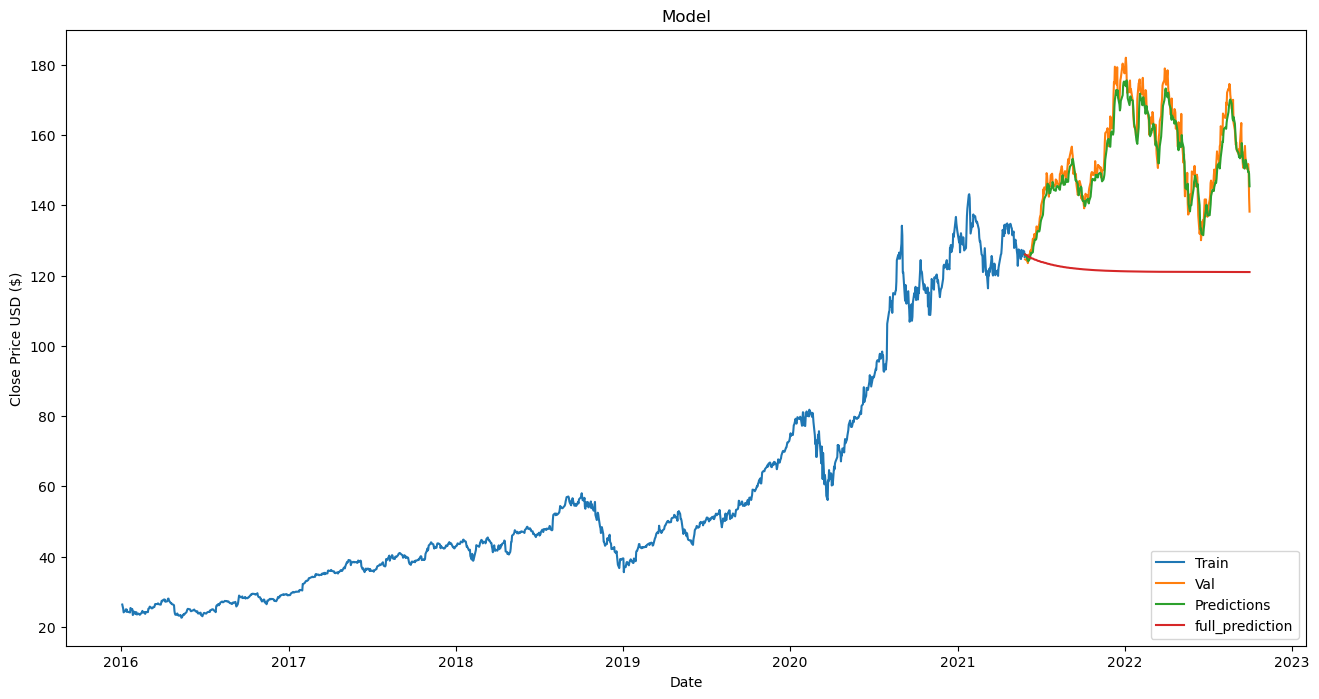

In [16]:
from matplotlib import pyplot as plt
# stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')

data1 = stock_data.filter(['Close'])
train = data1[:train_len]
validation = data1[train_len:]
validation['full_prediction'] = full_prediction 
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions','full_prediction']])
plt.legend(['Train', 'Val', 'Predictions', 'full_prediction'], loc='lower right')
plt.show()